## Importing all the necessary libraries

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
!pip install graphviz

In [29]:
!pip install pydot

In [30]:
!pip install wget

In [31]:
!python -m wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py


Saved under helper_prabowo_ml (1).py


In [4]:
!pip install transformers

In [12]:
!pip install tensorflow

In [32]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers.legacy import Adam as legacyAdam

## Loading the train, validation and test datasets

In [33]:
train = pd.read_csv("data/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("data/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("data/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [34]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,210,i feel pretty rotten,sadness
1,3801,i feel more irritated than peaceful,anger
2,9442,i know that feeling myself the strange sense o...,fear
3,14632,i just ran by feel and i m glad i didn t look ...,joy
4,4008,i have the feeling i am going to be tortured t...,fear


In [35]:
df.drop('index',axis=1,inplace=True)

In [36]:
df.shape

(2000, 2)

## Text Preprocessing

In [37]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [38]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,feel pretty rotte,sadness
1,feel irritated peacefu,anger
2,ow feeling strange sense serendipity minds col...,fear
3,ran feel glad look probably would freaked happ...,joy
4,feeling going tortured tonight,fear


In [39]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [40]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,feel pretty rotte,sadness,17
1,feel irritated peacefu,anger,22
2,ow feeling strange sense serendipity minds col...,fear,56
3,ran feel glad look probably would freaked happ...,joy,68
4,feeling going tortured tonight,fear,30


In [41]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [42]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [43]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


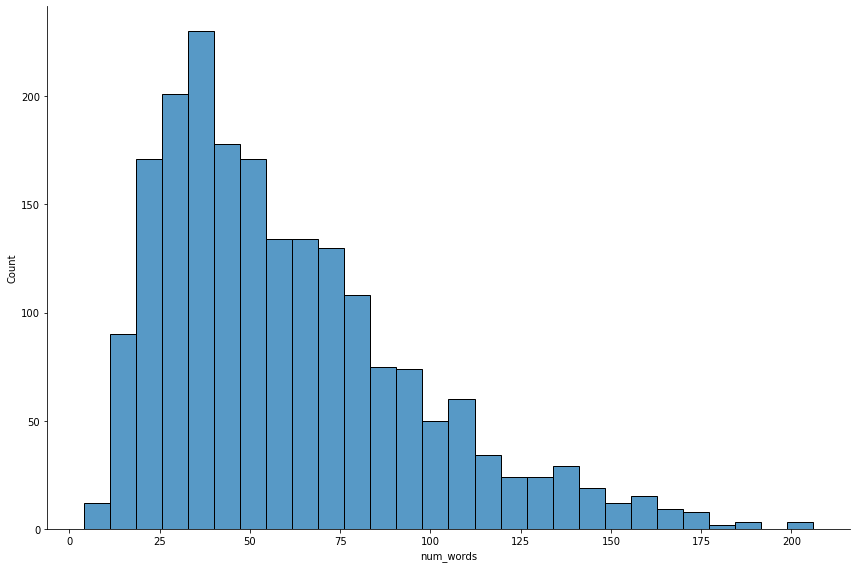

In [44]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [45]:
max_len = 40

## Text Tokenization

In [46]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [47]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [48]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [49]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=legacyAdam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [50]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [51]:
train_data.head()

,Input,Sentiment,num_words,Label
446,ve gotten used extent im actually feeling weir...,surprise,55,5
1838,feel intimidated girls acne getting rid pimples,fear,47,1
1423,want snap simply feel simply live laugh enjoy ...,sadness,65,4
1578,push back repressed expressions child split ma...,anger,152,0
1326,ow later read ill feel regretful ive posted th...,sadness,62,4


In [52]:
test_data.head()

,Input,Sentiment,num_words,Label
1310,still remember teenager giddy feeling amazemen...,love,109,3
1635,m trying positive feel positive,joy,31,2
1078,feel people shamed,sadness,18,4
337,remember going shandur highest polo ground wor...,sadness,154,4
1654,ve struggled feeling inadequate subpar various...,sadness,69,4


## Generating the model summary and plot

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

In [54]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training and fine-tuning the pretrained BERT model 

In [55]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 1.5278 - balanced_accuracy: 0.4271

ValueError: in user code:

    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\engine\training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\engine\training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\engine\training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\engine\training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\stanl\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 40), found shape=(None, 35)


## Analyzing model performance

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [ ]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.